# Using repeated cross-sectional survey data from the Australian public service to predict employees' intent to leave

**Background**
- I was a Research Data Analyst at Johns Hopkins University between September 2018-August 2020. There, I investigated the effects of management practices on employee attitudes (ex: job satisfaction, intrinsic motivation, and intent to leave).  I built linear regression models to test four hypotheses using repeated cross-sectional data from six large public employee surveys across different years.  
- Using the public employee  survey data, I also built predictive models to predict employees' intent to leave using their perception of the workplace environment and management practices.  I will mainly focus on replicating this part of my work  in this notebook.
- A measurement model that relates survey items to latent constructs (for management practices and employee attitudes) was specified based on organization behaviour theories, and information from reports/codebook from some (but not all) of the public employee surveys.  
- The measurement model was verified using confirmatory factor analysis (CFA) in STATA.  Note that I will not replicate the CFA in this notebook; instead I will only use the results from CFA to develop my latent constructs from item scores.
<br>

**Objective of this notebook**
- The objective of this notebook is to replicate some of my work as a Research Data Analyst at Johns Hopkins University.  
- In this notebook, I will use only one of the six public survey datasets-- the Australia Public Employee Survey (APS) to do the following:
    - First, I want to demonstrate that data on employee attitudes and management practices from public employee surveys is informative in predicting employees' intent to leave.
    - Second, I want to test the hypothesis that individuals reporting higher levels of intrinsic motivation see a differentially greater effect of supportive management practices on their intention to leave an agency.  In other words, more intrinsically motivated individuals are more sensitive to management practice in assessing whether they wish to leave their positions than their less intrinsically motivated coworkers, all else equal.  This suggests that unsupportive management practices may induce adverse selection out of an agency, with the more intrinsically motivated differentially likely to exit, and the less intrinsically motivated differentially likely to remain.


In [203]:
'''data'''
import pandas as pd
import numpy as np
from sklearn.externals import joblib
from collections import Counter
from sklearn.preprocessing import StandardScaler

%run helpers.ipynb


'''plots'''
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


'''model selection'''
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE

'''metrics'''
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import auc, roc_curve, roc_auc_score

'''ML methods'''
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier as XGBClassifier
import statsmodels.api as sm
from sklearn.pipeline import Pipeline

## Data Processing

In [2]:
df_2019 = process_data(2019)


********************
The missing value count and percentage of each item:
      Total  Percent
q77e   8084     7.74
q77d   7660     7.33
q77c   7513     7.19
q77b   7409     7.09
q60d   6450     6.17
q60a   6357     6.08
q72d   6249     5.98
q72b   6198     5.93
q59    6169     5.90
q46    5626     5.39

********************
I kept 95 % of respondent with missing value less than 20%

********************
The shape of the Dataframe for all selected items is:(99358, 68)

********************
                    Total  Percent
intent_to_leave      1041     1.05
qual_upr_mgmt         577     0.58
mgr_fb                524     0.53
employee_inclusion    405     0.41
fair_rwd              285     0.29
promote_ethics        284     0.29
autonomy              247     0.25
wpi_o                 229     0.23
job_satisfaction      183     0.18
pay_satisfaction      179     0.18

********************
I lose 0.038245536343324144 % of data after the removal of NA respondents


In [3]:
df_2018 = process_data(2018)


********************
The missing value count and percentage of each item:
      Total  Percent
q74e   7401     7.18
q74d   7032     6.82
q74c   6894     6.68
q74b   6773     6.57
q77d   6517     6.32
q77b   6415     6.22
q63g   6357     6.16
q63e   6154     5.97
q63f   6099     5.91
q63d   6000     5.82

********************
I kept 94 % of respondent with missing value less than 20%

********************
The shape of the Dataframe for all selected items is:(97333, 73)

********************
                    Total  Percent
intent_to_leave       900     0.92
qual_upr_mgmt         836     0.86
employee_inclusion    431     0.44
fair_rwd              362     0.37
promote_ethics        310     0.32
autonomy              274     0.28
wpi_o                 206     0.21
safety                172     0.18
pay_satisfaction      167     0.17
skills_match           91     0.09

********************
I lose 0.03592820523357957 % of data after the removal of NA respondents


In [4]:
df_2017 = process_data(2017)
df_2017['gender_Prefer not to say'] = 0 
df_2017 = df_2017.sort_index(axis=1) # sort column by column names


********************
The missing value count and percentage of each item:
      Total  Percent
q81e   8234     8.28
q81d   7898     7.94
q81c   7837     7.88
q81b   7711     7.76
q48    6237     6.27
q42f   5801     5.84
q42d   5603     5.64
q42e   5596     5.63
q42c   5556     5.59
q42a   5503     5.54

********************
I kept 94 % of respondent with missing value less than 20%

********************
The shape of the Dataframe for all selected items is:(94143, 57)

********************
                    Total  Percent
intent_to_leave      1451     1.54
qual_upr_mgmt        1069     1.14
employee_inclusion    545     0.58
fair_rwd              446     0.47
resources             316     0.34
autonomy              261     0.28
promote_ethics        242     0.26
mgr_fb                231     0.25
clear_obj             219     0.23
safety                205     0.22

********************
I lose 0.052250300075417186 % of data after the removal of NA respondents


**Aggregating the repeated cross-sectional data**

In [5]:
data = pd.concat([df_2019, df_2018, df_2017], axis=0)

In [6]:
data.shape

(278618, 30)

In [7]:
# check for missing values
data.isnull().sum()

age_55 years or older                            0
age_Under 40 years                               0
autonomy                                         0
clear_obj                                        0
coworkers_perf                                   0
creativity                                       0
dev                                              0
employee_inclusion                               0
fair_rwd                                         0
gender_Male                                      0
gender_Prefer not to say                         0
gender_X (Indeterminate/Intersex/Unspecified)    0
intent_to_leave                                  0
intrinsic_motivation                             0
job_satisfaction                                 0
mgr_fb                                           0
org_pride                                        0
org_size_Medium (251 to 1,000 employees)         0
org_size_Small (Less than 250 employees)         0
pay_satisfaction               

**Sample 20k respondents**
- For this notebook, I will only work with a much smaller subset of the dataset. I will randomly sample 20 k respondents and perform analysis and modelling.

In [8]:
data = data.sample(n=20000, random_state= 10)

##  Exploratory Analysis

In [9]:
items = pd.read_excel("data/aust_aps_items.xlsx", sheet_name="2019") 
practices = items.loc[items.Type == "mgmt_practice", "Factor"].unique().tolist()
attitudes = items.loc[items.Type == "employee_attitudes", "Factor"].unique().tolist()
attitudes.remove("intent_to_leave")

In [10]:
print("The management practices are: {}".format(practices))
print("")
print("I have {} management practices.".format(len(practices)))

The management practices are: ['clear_obj', 'skills_match', 'qual_upr_mgmt', 'fair_rwd', 'autonomy', 'dev', 'well_being', 'coworkers_perf', 'resources', 'promote_ethics', 'mgr_fb', 'creativity', 'pay_satisfaction', 'qual_supervisor', 'safety']

I have 15 management practices.


In [11]:
print("The employee attitudes are: {}".format(attitudes))
print("")
print("I have {} employee attitudes.".format(len(attitudes)))

The employee attitudes are: ['employee_inclusion', 'job_satisfaction', 'wpi_o', 'wpi_c', 'org_pride', 'intrinsic_motivation']

I have 6 employee attitudes.


**Probability distribution of employee attitudes and management practices.**

In [12]:
data.intent_to_leave.value_counts(normalize=True)

0.0    0.74215
1.0    0.25785
Name: intent_to_leave, dtype: float64

**Thoughts**
- There is an over-whelming number of workers that do not want to leave. I will need to rebalance the class later on before building the classifiers.

**Look at the probability distributions of several management practices and employee attitudes**

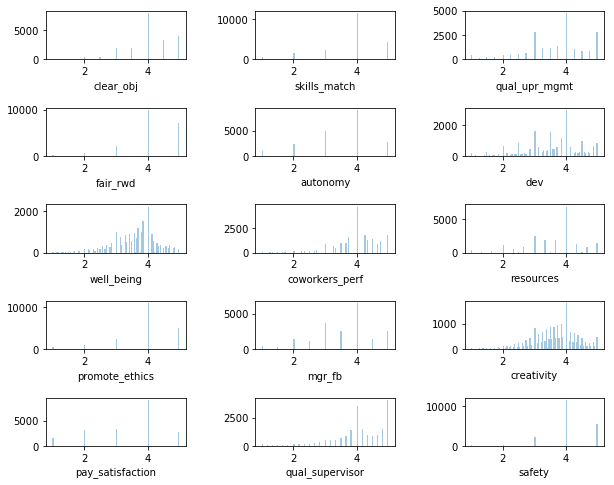

In [13]:
temp = np.array(practices).reshape(5,3)
fig,axes = plt.subplots(5,3,figsize=(10,8))
for i in range(5):
    for j in range(3):
        sns.distplot(data[temp[i,j]], bins=100, hist=True, kde=False, ax = axes[i,j])
plt.subplots_adjust(wspace=0.5, hspace=1) # width and height space between plots

**All are slightly left skewed and 4 is the most common construct score.**

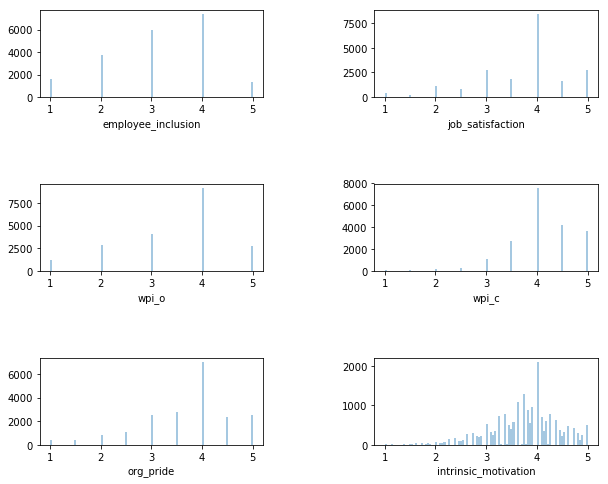

In [14]:
temp = np.array(attitudes).reshape(3,2)
fig,axes = plt.subplots(3,2,figsize=(10,8))
for i in range(3):
    for j in range(2):
        sns.distplot(data[temp[i,j]], bins=100, hist=True, kde=False, ax = axes[i,j])
plt.subplots_adjust(wspace=0.5, hspace=1) # width and height space between plots

**Again, all are slightly left skewed and "4" is the most common construct score.**

**From the employee surveys of other countries (ex: US), I observed that:**
- clear_obj, skills_match, autonomy, extrinsic motivation, job satisfction are highly correlated with intent_to_leave
- clear_obj, skills_match, fair_rwd, autonomy is positively associated with intrinsic motivation.
- Higher intrinsic motivation kindles the effect of management practices on intent to leave. 

**Let's explore the Australia APS dataset and see if they follow the same pattern.**

In [15]:
temp = ["clear_obj", "skills_match", "fair_rwd", "autonomy", 
        "promote_ethics", "mgr_fb", "pay_satisfaction", "safety",
        "wpi_o", "job_satisfaction"]
temp = np.array(temp).reshape(5,2)

C:\Users\henry_dw8mcdk\Anaconda3\envs\python35\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


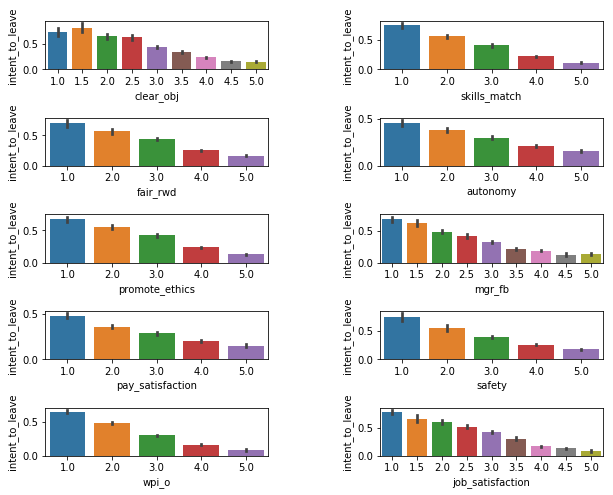

In [16]:
fig,axes = plt.subplots(5,2,figsize=(10,8))
for i in range(5):
    for j in range(2):
        sns.barplot(y="intent_to_leave", x=temp[i,j],data = data, ax = axes[i,j])
plt.subplots_adjust(wspace=0.5, hspace=1) # width and height space between plots

**Higher scores in the above management practices is associated with lower proportion of employee intending to leave.  In addition, job satisfaction and wpi_outward recgonition (a measure of extrinsic motivation) is negatively assocatied with intent to leave.**

In [17]:
temp2 = [col for col in practices if col not in temp]
temp2.append("intrinsic_motivation")
temp2 = np.array(temp2).reshape(4,2)

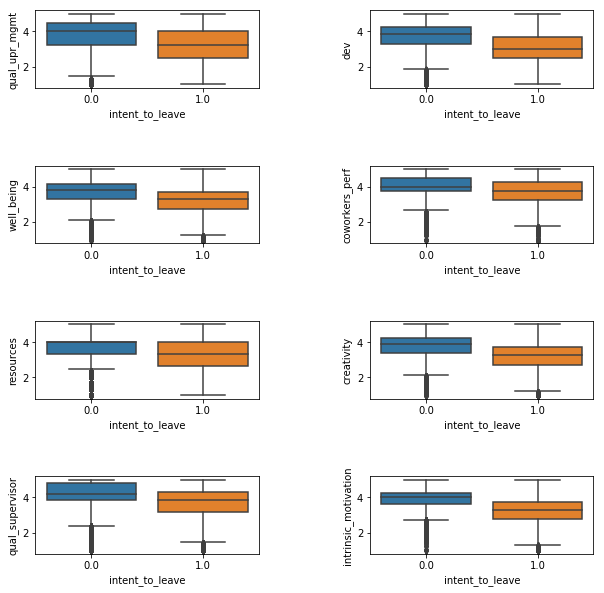

In [18]:
fig,axes = plt.subplots(4,2,figsize=(10,10))
for i in range(4):
    for j in range(2):
        sns.boxplot(x="intent_to_leave", y=temp2[i,j],data = data, ax = axes[i,j])
plt.subplots_adjust(wspace=0.5, hspace=1) # width and height space between plots

**Employees who do not intent to leave tend to have higher average scores in management practice and employee attitude.** 

## Correlation between variables
- Check for highly correlated management practices and highly correlated employee attitudes, I might want to exclude some of the practices/attitudes to avoid near-perfect collinearity in my regression models.

In [19]:
correlation_analysis(data[practices], "../output/correlation_practices.csv")

**Highly correlated management practices (above 0.5):**
- (fair_rwd, qual_supervisor): drop qual_supervisor
- (creativity, dev): drop creativity
- (dev, mgr_fb): drop mgr_fb
- (fair_rwd, dev): drop dev
- (well_being, resources): drop resources
- In summary, drop qual_supervisor, creativity, mgr_fb, dev, and resources

In [20]:
correlation_analysis(data[attitudes], "../output/correlation_attitudes.csv")

**Highly correlated employee attitudes (above 0.5):**
- (org_pride, intrinisic motivation): drop org_pride
- (employee_inclusion, intrinsic_motivation): drop employee inclusion
- (wpi_c, intrinsic motivation): drop wpi_c
- (job_satisfaction, intrinsic motivation)
- (intrinsic motivation, wpi_o)
- In summary: drop org_pride, wpi_c, employee_inclusion.  I keep job satisfaction, intrinsc motivation, and wpi_o

## Feature Selection
- We can use either two of the below approaches:
    - Drop highly correlated features for models where near perfect multicollinearity is a concern (see the previous section)
    - For logitistic regression, where multicollinearity is a concern, perform lasso regression so that some coefficients will be regularized to zero.  I will use GridSearchCV to tune alpha (the shrinkage penalty term in lasso).  I will keep the full set of management practices for KNN, SVC and tree models that are not sensitive to multicollinearity. 

## Predictive Modelling
- Logisitic Regression
- Random Forest
- XGBoost

In [21]:
X= data.drop("intent_to_leave", axis=1) # drop intent_to_leave
X.drop(attitudes, axis=1, inplace=True) # drop employee attitudes
feature_names = list(X.columns.values) # save the feature names
X=np.array(X)

In [22]:
y = data["intent_to_leave"].astype(int)
y= np.array(y)

**Train test split**

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

**Baseline prediction**
- Establish a naive prediction-- if the models that we built cannot outperform a naive guess, then we have to admit that ML is not suitable for this problem (maybe we need more data, or there is a simplier solution that does not require machine learning).

In [24]:
Counter(y_train)

Counter({0: 11105, 1: 3895})

In [25]:
# since 0 is the most frequent class, my naive guess is 0 for all respondents
baseline_guess = np.zeros(len(y_test))

In [26]:
print("The accuracy score of my baseline model is {}".format(round(accuracy_score(baseline_guess,y_test),2)))
print("")
print("The classification report of my baseline model:")
print(classification_report(baseline_guess,y_test))

The accuracy score of my baseline model is 0.75

The classification report of my baseline model:
             precision    recall  f1-score   support

        0.0       1.00      0.75      0.86      5000
        1.0       0.00      0.00      0.00         0

avg / total       1.00      0.75      0.86      5000



C:\Users\henry_dw8mcdk\Anaconda3\envs\python35\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


**Generate Synthetic samples to ameliorate imbalanced classes** 
- Use imblearn’s SMOTE(Synthetic Minority Oversampling Technique) to upsample my minority class. 
- SMOTE uses a nearest neighbors algorithm to generate new and synthetic data we can use for training our model.
- Only apply SMOTE to train data to avoid data leakage.
- Reference: https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18
- Reference: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [27]:
execute = True
if execute:
    sm = SMOTE() # init the smote model
    X_train, y_train = sm.fit_sample(X_train, y_train) # fit the model to train data
    Counter(y_train) # The classes are now balanced by upsampling the minority class 1

## Logistic Regression
- Use GridSearchCV to select gamma, the parameter for the penalty term in the L1 regularization
- No standardization is needed since my items and construct scores have the same scale.

In [28]:
pipe_lr = Pipeline([('clf', LogisticRegression(penalty = 'l1', 
                                               solver = 'liblinear',
                                               random_state=10))]) # pipeline for logreg

grid_params_lr = {'clf__C':[0.1,0.5,1,5,10]} # variance of model decreases as C increase

In [29]:
execute = False
if execute:
    # init GridSearch object
    gs_lr = GridSearchCV(estimator=pipe_lr,
                     param_grid=grid_params_lr,
                     scoring='f1',
                     cv=5,
                     n_jobs = -1,
                     verbose = 2)
    gs_lr.fit(X_train,y_train) # fit model
    print("The best parameters are: {}".format(gs_lr.best_params_))
    
    joblib.dump(gs_lr, '../saved_models/gs_lr.pkl') # save GridSearchCV object

In [30]:
# load model
gs_lr =joblib.load('../saved_models/gs_lr.pkl')

In [31]:
y_pred_lr = gs_lr.predict(X_test)

In [32]:
print(classification_report(y_pred_lr,y_test))

             precision    recall  f1-score   support

          0       0.75      0.87      0.81      3207
          1       0.68      0.48      0.56      1793

avg / total       0.72      0.73      0.72      5000



**Compared with the baseline guess, the f1 score for class 0 reduced slightly, but the precision, recall, and f1-score of class 1 is no longer zero (though still low).  On the whole, logistic regression is an improvement on our baseline.**

In [33]:
logreg = gs_lr.best_estimator_.named_steps["clf"] # get the best logreg model
params = np.append(logreg.intercept_,logreg.coef_)
feature_names.insert(0,"constant")

In [34]:
df_coeff = pd.DataFrame(list(zip(feature_names, params)), columns = ["features","coeff"])
print(df_coeff.sort_values(by="coeff"))

                                         features     coeff
22                                     well_being -0.509614
7                                             dev -0.450633
21                                   skills_match -0.338086
5                                  coworkers_perf -0.323780
4                                       clear_obj -0.243337
16                                 promote_ethics -0.187848
6                                      creativity -0.166112
12                                         mgr_fb -0.077794
15                               pay_satisfaction -0.060623
18                                  qual_upr_mgmt -0.054763
1                           age_55 years or older -0.042032
19                                      resources -0.036838
23                                           year  0.001910
10                       gender_Prefer not to say  0.031377
3                                        autonomy  0.054205
11  gender_X (Indeterminate/Intersex/Uns

**Surprisingly, autonomy and fair_rwd are have coefficients that were regularized to close to 0.  However, the effect sizes of clear objective and skills match are large (similar to what we see in other survey datasets).**

## Random Forest
- Due to resource constraints, I want to reduce the computational time, I will try to sample a subset of the data for training. Perhaps a 20k sample is sufficient to get a decent result.

In [35]:
pipe_rf = Pipeline([('scl',StandardScaler()),
                    ('clf', RandomForestClassifier(random_state=10))]) 

grid_params_rf = { 
        "clf__n_estimators" : [200, 800, 1000], 
        "clf__max_depth"      : [10,15,20,50,80],  
        "clf__min_samples_split" : [2,5],  # [2, 5, 10]
        "clf__min_samples_leaf" :   [1,2,4]   # [1, 2, 4]  
    }

In [36]:
execute = False
if execute:
    # init GridSearch object
    gs_rf = GridSearchCV(estimator=pipe_rf,
                     param_grid=grid_params_rf,
                     scoring='f1',
                     cv=5,
                     n_jobs = -1,
                     verbose = 2)
    gs_rf.fit(X_train,y_train) # fit model
    print("The best parameters are: {}".format(gs_rf.best_params_))
    
    joblib.dump(gs_rf, '../saved_models/gs_rf.pkl') # save GridSearchCV object

In [37]:
# load model
gs_rf =joblib.load('../saved_models/gs_rf.pkl')

In [39]:
y_pred_rf = gs_rf.predict(X_test)

In [40]:
print("The accuracy of the tuned Random Forest model (on test data) is {}".format(accuracy_score(y_pred_rf, y_test)))

The accuracy of the tuned Random Forest model (on test data) is 0.7862


In [41]:
print(classification_report(y_pred_rf, y_test))

             precision    recall  f1-score   support

          0       0.90      0.83      0.86      4085
          1       0.44      0.61      0.51       915

avg / total       0.82      0.79      0.80      5000



In [42]:
best_rf_model = gs_rf.best_estimator_.named_steps['clf']

**Thoughts**
- Compared to logistic regression, the precision score for class 0 is much higher but at the cost of lower precision score for class 1.  This means the Random Forest model is an improvement over logistic regression in providing correct prediction on negative outcomes (stayers) but not as good in providing prediction on positive outcomes (leavers).

- RF however has a higher recall score for leavers (class 1), meaning that a larger proportion of actual leavers were correctly predicted by the RF model compared to logistic regression.

- For the purposes of these models, I might be interested in a model with higher recall scores since false-negatives is a concern. The cost of failing to identifying actual leavers or misclassifying a stayer as a leaver is high since the human resource team will not be able to set the correct headcount/budget for recruitment at the start of year.

##  Feature importance
- See which feature is the most "importance" in the RF model.  Important features are those that lead to the largest average reduction in the loss (Gini) during tree-building.

In [78]:
feature_importance = pd.DataFrame({'feature': feature_names[1:],  
                                 'importance': gs_rf.best_estimator_.named_steps['clf'].feature_importances_})

# Show the top 10 most important
feature_importance = feature_importance.sort_values('importance', ascending = False).reset_index(drop=True)

feature_importance.head(10)

,feature,importance
0,well_being,0.102514
1,dev,0.100788
2,creativity,0.090379
3,resources,0.076179
4,coworkers_perf,0.071494
5,clear_obj,0.064658
6,qual_upr_mgmt,0.062516
7,skills_match,0.056160
8,qual_supervisor,0.053776
9,mgr_fb,0.052004


**Well-being, dev, and creativity are most informative in predicting employees' intent to leave.**

<Figure size 1440x1440 with 0 Axes>

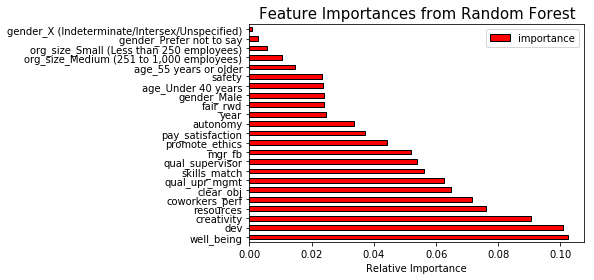

In [88]:
fig = plt.figure (figsize=(20,20))
# Plot the 10 most important features in a horizontal bar chart
feature_importance.plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'red');
plt.xlabel('Relative Importance', size = 10); plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 15);

## XGBoost
Reference: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

Hyperparameters:
- eta (learning rate): similar to learning rate in GBM, makes the model more robust by shrinking the weights on each step
    - Typical final values: 0.01 - 0.2
- min_child_weight (default 1):  specifies the minimum sum of weights of all observations required in a child.  Used to control overfitting-- higher values prevent a model from capturing naunces in the training sample for a tree. Needs to be tuned using CV.
- max_depth (default 6): maximum depth of a tree, used to control overfitting as a deeper tree will capture more naunces of a particular train sample.
    - Typical final values: 3-10
- max_leaf_nodes: Maximum number of terminal nodes/leaves in a tree.  Can be defined in place of max_depth.  If this is set, max_depth will be ignored.
- gamma: a node is split only when the resulting split gives a reduction in the loss function; gamma specifies the min loss reduction required to make a split.  Higher values of gamma makes the algorithm more conservative.
- subsample: Specifies the fraction fo observations to be used to train each tree.  Low values make algorithm more conservative and prevents overfitting, but if the values are too low, I might have underfitting.
    - Typical final values: 0.5-1
- colsample_bytree: similar to max_features in GBM.  Specifies the fraction of features to be considered for each tree.
    - Typical values: 0.5 to 1
- alpha (reg_alpha): L1 regulariation term on weights, I would use it only if I have lots of features and I would like to reduce some of them so that the algorithm will run faster and I get a more parsimonious model.
    
I will start with a relatively high learning rate (around 0.1). Deterimine the optimum number of trees for this learning rate.  I need to tune tree-specfic parameters like max_depth, min_child_wieght, subsample, colsample_bytree and gamma. I can then further tune learning rate to improve performance.

In [55]:
pipe_xgb = Pipeline([('scl',StandardScaler()),
                    ('clf', XGBClassifier(objective="binary:logistic", learning_rate= 0.05, random_state=10))]) 

grid_params_xgb = { 
        "clf__n_estimators" : [100, 1000], 
        "clf__max_depth"      : [2,6],  
        "clf__min_child_weight" : [1,3,5],  
        "clf__gamma" :   [0.1,0.5],
        "clf__subsample" : [0.4,0.8],
        "clf__colsample_bytree":[0.2,0.8]
    }

In [56]:
execute = False
if execute:
    # init GridSearch object
    gs_xgb = GridSearchCV(estimator=pipe_xgb,
                     param_grid=grid_params_xgb,
                     scoring='f1',
                     cv=5,
                     n_jobs = -1,
                     verbose = 2)
    gs_xgb.fit(X_train,y_train) # fit model
    print("The best parameters are: {}".format(gs_xgb.best_params_))
    joblib.dump(gs_rf, '../saved_models/gs_xgb.pkl') # save GridSearchCV object

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 27.5min finished


The best parameters are: {'clf__min_child_weight': 3, 'clf__subsample': 0.4, 'clf__colsample_bytree': 0.8, 'clf__n_estimators': 100, 'clf__max_depth': 6, 'clf__gamma': 0.1}


In [ ]:
# load model
gs_xgb =joblib.load('../saved_models/gs_xgb.pkl')

In [69]:
y_pred_xgb = gs_xgb.predict(X_test)

In [71]:
print("The accuracy of the tuned XGBoostClassifer model (on test data) is {}".format(accuracy_score(y_pred_xgb, y_test)))

The accuracy of the tuned XGBoostClassifer model (on test data) is 0.7872


In [72]:
print(classification_report(y_pred_xgb, y_test))

             precision    recall  f1-score   support

          0       0.90      0.83      0.86      4058
          1       0.45      0.61      0.52       942

avg / total       0.82      0.79      0.80      5000



**Performance is pretty much the same as Random Forest.**

## AUC-ROC for the Random Forest Classifier

In [89]:
from sklearn.metrics import roc_curve, auc

**Compute the FPR and TPR of the predictions.  The ROC curve will be plotted in the FPR(y)-TPR(x) space for different threshold values.**

In [101]:
y_prob_rf = gs_rf.predict_proba(X_test) # get probability score for class= 0 and class= 1

In [108]:
# FPR: Fallout = false positive rate = FP/total number of negative events that are predicted by the model
# TPR: true positive rate:  TPR = Recall = TP/total number of positive events that is predicted by the model
FPR, TPR, thresholds = roc_curve(y_test, y_prob_rf[:,1]) # use prob score for class 1
type(FPR), type(TPR), type(thresholds)

(numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [110]:
# ROC plots 899 points in the FPR-TPR space, one point for each threshold 0 to 1
FPR.shape, thresholds.shape   

((899,), (899,))

In [111]:
ROC_AUC = auc(FPR, TPR)  # AUC area under the curve

print("The area under the curve (AUC) is: {}".format(ROC_AUC))

The area under the curve (AUC) is: 0.7783427835423062


**Alternatively, use roc_auc_score from sklearn.  The inputs are y_test, and probability score of the larger label.**

In [123]:
print("ROC_AUC score is: {}".format(roc_auc_score(y_test, y_prob_rf[:,1])))

ROC_AUC score is: 0.7783427835423062


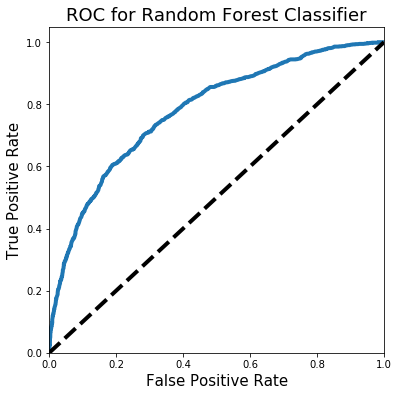

In [115]:
plt.figure(figsize =[6,6])
plt.plot(FPR, TPR, label= 'ROC curve(area = %0.2f)'%ROC_AUC, linewidth= 4)  # plot FPR and TPR
plt.plot([0,1],[0,1], 'k--', linewidth = 4) # 45 deg line
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.title('ROC for Random Forest Classifier', fontsize= 18)
plt.show()

## Statistical Inference 
- Investigate the hetrogeneous effects of management practices on intent to leave for employees' with different levels of intrinsic motivation

**Generate interaction terms for the top 6 important features in RF with intrinsic motivation**

In [205]:
# a list of top 6 important feature from the Random Forest classifier 
important_features = list(feature_importance.iloc[:6,0])

In [206]:
temp = important_features.copy()
temp.append("intrinsic_motivation")

In [213]:
X= data[temp]
X = gen_interaction(X,important_features,"intrinsic_motivation")
feat_interact_names = list(X.columns.values) # save the feature names

**I will use full data to perform statistical inference**

In [215]:
y = data["intent_to_leave"]

**Regress intent_to_leave on "important features" and their interaction with intrinsic motivation**

In [ ]:
X = sm.add_constant(X) # add constant

In [221]:
# Logit model
logit_mod = sm.Logit(y,X)
logit_res = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.449110
         Iterations 7


In [222]:
print(logit_res.summary())

                           Logit Regression Results                           
Dep. Variable:        intent_to_leave   No. Observations:                20000
Model:                          Logit   Df Residuals:                    19986
Method:                           MLE   Df Model:                           13
Date:                Mon, 06 Jul 2020   Pseudo R-squ.:                  0.2132
Time:                        17:37:52   Log-Likelihood:                -8982.2
converged:                       True   LL-Null:                       -11416.
                                        LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   7.3398      0.694     10.574      0.000       5.979       8.700
well_being                             -0.2231      0.20

**Thoughts** 
- For well-being, personal development, creativity, and resources, its effect on employees' intent to leave is "higher" (reduces intent to leave) for employees for higher scores in intrinsic motivaation.  In other words, many important supportive management practices matters more for employees with higher levels of intrinsic motivation.  
- This suggests that unsupportive management practices may induce adverse selection out of an agency, with the more intrinsically motivated differentially likely to exit, and the less intrinsically motivated differentially likely to remain. 
- The inverse is also true; these results suggest supportive management practices are differentially likely to retain more intrinsically motivated employees, as seen in their stated intent to leave the organization.  